In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## 1. Sudoku Count

In [2]:
sudoku_count = pd.read_csv('dbsudoku-counts.txt', sep='\t', header=None)

In [3]:
sudoku_count.shape

(311919, 8)

In [4]:
count_col = ['user_id','level','best_time','solved','solved_wo_error','solved_w_error','tot_time','tot_time_sq']
sudoku_count.columns=count_col
sudoku_count.head()

,user_id,level,best_time,solved,solved_wo_error,solved_w_error,tot_time,tot_time_sq
0,1,1,506,1,1,0,506,256036
1,2,1,79,12,11,1,2307,511683
2,2,2,65,2,1,1,131,8581
3,2,4,294,2,2,0,1556,1679080
4,3,1,190,1,1,0,190,36100


In [5]:
sudoku_count.describe()

,user_id,level,best_time,solved,solved_wo_error,solved_w_error,tot_time,tot_time_sq
count,311919.000000,311919.000000,311919.000000,311919.000000,311919.000000,311919.000000,3.119190e+05,3.119190e+05
mean,120436.050051,1.975465,747.089010,75.901513,47.983384,11.826942,4.933929e+04,5.688533e+07
std,76103.581829,1.077941,721.847279,521.723739,419.097424,130.329641,2.691726e+05,3.307734e+08
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,52334.500000,1.000000,336.000000,2.000000,0.000000,0.000000,1.461000e+03,1.117470e+06
50%,115705.000000,2.000000,533.000000,4.000000,1.000000,0.000000,4.154000e+03,4.419530e+06
75%,186794.500000,3.000000,883.000000,20.000000,7.000000,2.000000,1.657350e+04,2.099462e+07
max,264690.000000,4.000000,7196.000000,78396.000000,78251.000000,30115.000000,2.906609e+07,3.144487e+10


In [6]:
sudoku_count.nunique()

user_id            196480
level                   4
best_time            5695
solved               3375
solved_wo_error      2805
solved_w_error       1229
tot_time            75453
tot_time_sq        239562
dtype: int64

## 2. Sudoku User

In [7]:
sudoku_user = pd.read_csv('dbsudoku-users.txt', sep='\t', header=None)

In [8]:
sudoku_user.shape

(264690, 5)

In [9]:
user_col = ['user_id','birth_year','country','us_state','gender']
sudoku_user.columns = user_col
sudoku_user.head()

,user_id,birth_year,country,us_state,gender
0,1,1976,il,NaN,m
1,2,1950,il,NaN,f
2,3,0,NaN,TX,NaN
3,4,0,NaN,NaN,NaN
4,5,1949,us,FL,m


In [10]:
sudoku_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264690 entries, 0 to 264689
Data columns (total 5 columns):
user_id       264690 non-null int64
birth_year    264690 non-null int64
country       173339 non-null object
us_state      84255 non-null object
gender        171121 non-null object
dtypes: int64(2), object(3)
memory usage: 10.1+ MB


In [11]:
sudoku_user.describe()

,user_id,birth_year
count,264690.000000,264690.000000
mean,132345.500000,1300.276905
std,76409.565713,935.261103
min,1.000000,0.000000
25%,66173.250000,0.000000
50%,132345.500000,1955.000000
75%,198517.750000,1985.000000
max,264690.000000,2017.000000


In [282]:
sudoku = sudoku_count.merge(sudoku_user)
print(sudoku.shape)
sudoku.head()

(311919, 12)


,user_id,level,best_time,solved,solved_wo_error,solved_w_error,tot_time,tot_time_sq,birth_year,country,us_state,gender
0,1,1,506,1,1,0,506,256036,1976,il,NaN,m
1,2,1,79,12,11,1,2307,511683,1950,il,NaN,f
2,2,2,65,2,1,1,131,8581,1950,il,NaN,f
3,2,4,294,2,2,0,1556,1679080,1950,il,NaN,f
4,3,1,190,1,1,0,190,36100,0,NaN,TX,NaN


# 3. EDA

In [283]:
row_initial = sudoku.shape[0]
sudoku = sudoku[sudoku['solved']!=0].copy()
print('Rows dropped:', row_initial-sudoku.shape[0])
print('Current size:', sudoku.shape)

Rows dropped: 776
Current size: (311143, 12)


### 3.1 Level

In [284]:
# pd.Series(sudoku['level'].value_counts())
level_info = pd.DataFrame(sudoku['level'].value_counts()).T.rename(index={'level':'count'})
level_info = level_info.append(pd.DataFrame(sudoku['level'].value_counts()/\
                                           sudoku['user_id'].nunique()*100).T.rename(index={'level':'pct %'}))
level_info = level_info.astype(object)
level_count = sudoku.groupby('user_id').count()['level'].reset_index(name='count')
for i in range(1,5):
    count = sudoku[(sudoku.user_id.isin(level_count[level_count['count']==1].user_id.tolist())) \
          & (sudoku.level==i)].shape[0]
    level_info.loc['only_count', i] = count
level_info.loc['pct %'] = level_info.loc['pct %'].apply(lambda x: round(x,1))
level_info.loc['only_to_all_pct %'] = level_info.loc['only_count'].apply(lambda x:
                                      round(x/sudoku.user_id.nunique() * 100,1))
level_info.loc['only_to_level_pct %'] = level_info.loc['only_count']/level_info.loc['count', :] * 100
level_info.loc['only_to_level_pct %'] = level_info.loc['only_to_level_pct %'].apply(lambda x: round(x,1))
cols = ['Easy', 'Medium', 'Hard', 'Evil']
level_info.columns = cols
level_info.head()

,Easy,Medium,Hard,Evil
count,143343,73154,53374,41272
pct %,73.1,37.3,27.2,21
only_count,84022,15858,11920,11791
only_to_all_pct %,42.8,8.1,6.1,6
only_to_level_pct %,58.6,21.7,22.3,28.6


In [285]:
ind = ['Player Count', 'Player %', 'Only This Level Count', 'Only This Level %(All)', 'Only This Level %']
level_info.index = ind
level_info.loc[level_info.index!='Only This Level %(All)',:]

,Easy,Medium,Hard,Evil
Player Count,143343,73154,53374,41272
Player %,73.1,37.3,27.2,21
Only This Level Count,84022,15858,11920,11791
Only This Level %,58.6,21.7,22.3,28.6


### 3.2 Solved, Average Time, Best Time and Total Time

In [286]:
sudoku['avg_time'] = sudoku['tot_time'] / sudoku['solved']

In [287]:
sudoku[sudoku['best_time']==0].shape

(193, 13)

In [288]:
for i in range(1,5):
    mean = sudoku[(sudoku['level']==i) & (sudoku['best_time']!=0)]['best_time'].mean()
    sudoku.loc[(sudoku['level']==i) & (sudoku['best_time']==0), 'best_time'] = mean

In [289]:
solved_info = pd.DataFrame(sudoku.groupby('level').mean()\
                           [['solved','tot_time','avg_time','best_time']]).T
solved_info.loc['solved'] = solved_info.loc['solved'].apply(lambda x: round(x)).astype(int)
solved_info.loc['tot_time'] = solved_info.loc['tot_time'].apply(lambda x:
                              str(int(x//3600))+':'+str(int(x%3600//60)).zfill(2)\
                              +':'+str(int(x%3600%60)).zfill(2))
solved_info.loc['avg_time'] = solved_info.loc['avg_time'].apply(lambda x:
                              str(int(x//3600))+':'+str(int(x%3600//60)).zfill(2)\
                              +':'+str(int(x%3600%60)).zfill(2))
solved_info.loc['best_time'] = solved_info.loc['best_time'].apply(lambda x:
                               str(int(x//3600))+':'+str(int(x%3600//60)).zfill(2)\
                               +':'+str(int(x%3600%60)).zfill(2))
solved_info

level,1,2,3,4
solved,49,71,101,147
tot_time,5:42:11,12:05:27,20:54:02,35:18:41
avg_time,0:13:33,0:17:58,0:21:26,0:24:04
best_time,0:09:57,0:13:03,0:15:13,0:16:42


In [290]:
grp = sudoku.groupby('user_id').sum()[['solved','level']].reset_index()
print(grp[grp['solved']==1].shape[0]/grp.shape[0])
print(grp[grp['solved']<6].shape[0]/grp.shape[0])

0.16505270243394984
0.47145603541032427


In [291]:
grp[grp['solved']==1].level.value_counts()/grp[grp['solved']==1].shape[0]

1    0.673000
2    0.144190
3    0.100967
4    0.081843
Name: level, dtype: float64

In [292]:
sudoku.groupby('level').sum()['solved']

level
1    6982616
2    5228573
3    5411252
4    6052683
Name: solved, dtype: int64

### 3.3 Accuracy

In [293]:
test=sudoku[sudoku['solved_wo_error']+sudoku['solved_w_error']!=0].copy()
test['accuracy'] = test[['solved_wo_error','solved_w_error']].apply(lambda x:
                     x[0]/(x[0]+x[1])*100, axis=1)
accuracy_by_level = test.groupby('level').mean()['accuracy'].tolist()
print('# of rows missing accuracy:', sudoku.shape[0]-test.shape[0])
print('% of rows missing accuracy:', (sudoku.shape[0]-test.shape[0])/sudoku.shape[0])
print('Accuracy level 1-4:', accuracy_by_level)

# of rows missing accuracy: 65804
% of rows missing accuracy: 0.2114911792969792
Accuracy level 1-4: [69.18435938825814, 67.95337895150946, 66.08645536286897, 58.0585419329109]


In [294]:
sudoku['accuracy'] = sudoku[['solved_wo_error','solved_w_error','level']].apply(lambda x:
                     x[0]/(x[0]+x[1])*100 if x[0]+x[1]!=0 else accuracy_by_level[x[2]-1], axis=1)

In [295]:
solved_info = pd.DataFrame(sudoku.groupby('level').mean()\
                           [['solved','tot_time','avg_time','best_time','accuracy']]).T
solved_info.loc['solved'] = solved_info.loc['solved'].apply(lambda x: round(x)).astype(int)
solved_info.loc['tot_time'] = solved_info.loc['tot_time'].apply(lambda x:
                              str(int(x//3600))+':'+str(int(x%3600//60)).zfill(2)\
                              +':'+str(int(x%3600%60)).zfill(2))
solved_info.loc['avg_time'] = solved_info.loc['avg_time'].apply(lambda x:
                              str(int(x//3600))+':'+str(int(x%3600//60)).zfill(2)\
                              +':'+str(int(x%3600%60)).zfill(2))
solved_info.loc['best_time'] = solved_info.loc['best_time'].apply(lambda x:
                               str(int(x//3600))+':'+str(int(x%3600//60)).zfill(2)\
                               +':'+str(int(x%3600%60)).zfill(2))
solved_info.loc['accuracy'] = solved_info.loc['accuracy'].apply(lambda x: round(x,1))
cols = ['Easy', 'Medium', 'Hard', 'Evil']
solved_info.columns = cols
solved_info

,Easy,Medium,Hard,Evil
solved,49,71,101,147
tot_time,5:42:11,12:05:27,20:54:02,35:18:41
avg_time,0:13:33,0:17:58,0:21:26,0:24:04
best_time,0:09:57,0:13:03,0:15:13,0:16:42
accuracy,69.2,68,66.1,58.1


In [296]:
ind = ['Puzzles Solved', 'Total Time', 'Average Time', 'Best Time', 'Accuracy %']
solved_info.index = ind
solved_info

,Easy,Medium,Hard,Evil
Puzzles Solved,49,71,101,147
Total Time,5:42:11,12:05:27,20:54:02,35:18:41
Average Time,0:13:33,0:17:58,0:21:26,0:24:04
Best Time,0:09:57,0:13:03,0:15:13,0:16:42
Accuracy %,69.2,68,66.1,58.1


### 3.4 Birth Year

In [297]:
print('{0:d} ({1:.1f}%) users are missing birth year info.'\
      .format(sudoku[sudoku['birth_year']==0]['user_id'].nunique(),
             round(sudoku[sudoku['birth_year']==0]['user_id'].nunique()/sudoku['user_id'].nunique()*100),1))

63963 (33.0%) users are missing birth year info.


In [298]:
sudoku[sudoku['birth_year']==0].shape[0]/sudoku.shape[0]

0.3033814034061509

In [299]:
sudoku['age'] = sudoku['birth_year'].apply(lambda x: 0 if x==0 else 2019-x)

In [300]:
no_age = sudoku[sudoku['birth_year']==0]
has_age = sudoku[sudoku['birth_year']!=0]
birth_year_info = pd.DataFrame(no_age[['solved','tot_time']].mean()).T.rename({0:'no_birth_year'})
birth_year_info = birth_year_info.append\
(pd.DataFrame(has_age[['solved','tot_time']].mean()).T.rename({0:'has_birth_year'}))
birth_year_info['solved'] = birth_year_info['solved'].apply(lambda x: round(x)).astype(int)
birth_year_info['tot_time'] = birth_year_info['tot_time'].apply(lambda x:
                              str(int(x//3600))+':'+str(int(x%3600//60)).zfill(2)\
                              +':'+str(int(x%3600%60)).zfill(2))
birth_year_info

,solved,tot_time
no_birth_year,56,10:32:18
has_birth_year,85,15:08:01


In [301]:
ind = ['Players Without Birth Year Data', 'Players With Birth Year Data']
birth_year_info.index = ind
cols = ['Puzzles Solved', 'Total Time']
birth_year_info.columns = cols
birth_year_info

,Puzzles Solved,Total Time
Players Without Birth Year Data,56,10:32:18
Players With Birth Year Data,85,15:08:01


In [302]:
row_initial = sudoku.shape[0]
sudoku = sudoku[sudoku['birth_year']!=0].copy()
print('Rows dropped:', row_initial-sudoku.shape[0])
print('Current size:', sudoku.shape)

Rows dropped: 94395
Current size: (216748, 15)


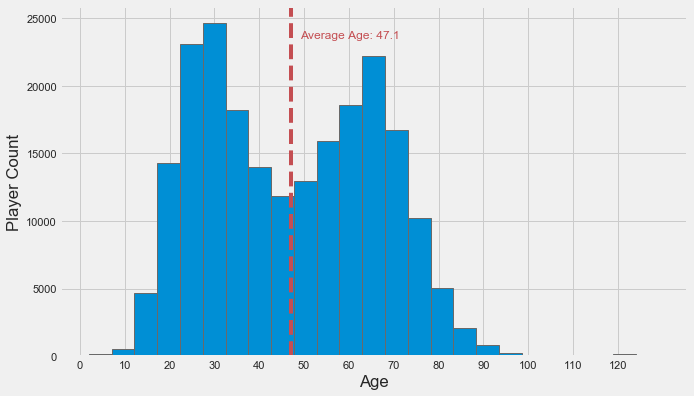

In [304]:
plt.figure(figsize=(10,6))
plt.hist(sudoku['age'],
         bins = 25)
plt.axvline(sudoku['age'].mean(), color='r', linestyle='--')
plt.annotate('Average Age: '+str(round(sudoku['age'].mean(),1)),
             (49,23500),
            color='r', fontsize=12)
plt.xticks(np.arange(0,121,10))
plt.ylabel('Player Count')
plt.xlabel('Age')
plt.show()

### 3.5 Country and US state

In [305]:
sudoku[sudoku['country'].isnull()]['user_id'].nunique()/sudoku['user_id'].nunique()

0.11779351889691081

In [306]:
sudoku['country'].nunique()

230

In [307]:
country_count = sudoku.groupby('user_id').first()['country'].value_counts().reset_index()
country_count.columns=['country','count']
country_count['pct_%'] = country_count['count']/sudoku.user_id.nunique()*100
country_count.head()

,country,count,pct_%
0,us,50085,37.903555
1,in,12381,9.369750
2,gb,10686,8.087000
3,ca,5668,4.289455
4,au,2658,2.011533


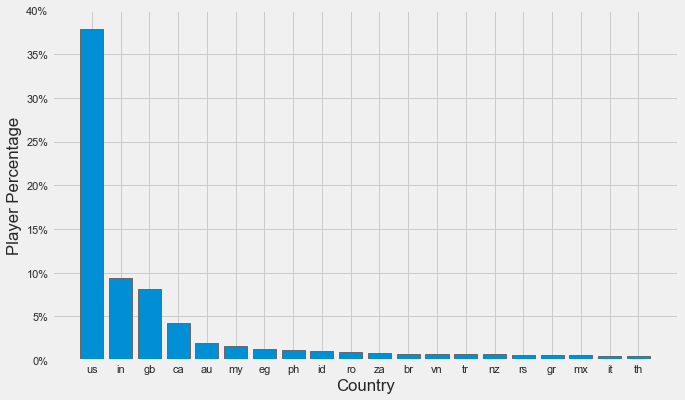

In [315]:
plt.figure(figsize=(10,6))
plt.bar(country_count.head(20)['country'],country_count.head(20)['pct_%'])
plt.yticks(np.arange(0,41,5),
           [str(i)+'%' for i in np.arange(0,41,5)])
plt.ylabel('Player Percentage')
plt.xlabel('Country')
#plt.xscale('log')
plt.show()

In [310]:
sudoku['us_state'].nunique()

51

In [311]:
sudoku['us_state'].count()

82523

In [312]:
state_count = sudoku.groupby('user_id').first()['us_state'].value_counts().reset_index()
state_count.columns=['us_state','count']
state_count['pct_%'] = state_count['count']/sudoku[sudoku['country']=='us']['user_id'].nunique()*100
state_count.head()

,us_state,count,pct_%
0,CA,6286,12.550664
1,TX,3771,7.529200
2,FL,3280,6.548867
3,NY,2783,5.556554
4,IL,2138,4.268743


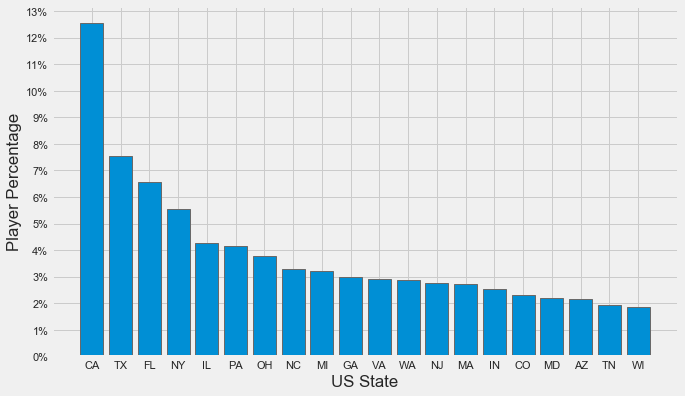

In [314]:
plt.figure(figsize=(10,6))
plt.bar(state_count.head(20)['us_state'],state_count.head(20)['pct_%'])
plt.yticks(np.arange(0,14,1),
           [str(i)+'%' for i in np.arange(0,14,1)])
plt.ylabel('Player Percentage')
plt.xlabel('US State')
plt.show()

### 3.6 Gender

In [41]:
print(sudoku[sudoku['gender'].isnull()]['user_id'].nunique())
print(sudoku.user_id.nunique())
print(sudoku[sudoku['gender'].isnull()]['user_id'].nunique()/sudoku.user_id.nunique())

9970
132138
0.07545142199821399


In [42]:
row_initial = sudoku.shape[0]
sudoku = sudoku[sudoku['gender'].notnull()].copy()
print('Rows dropped:', row_initial-sudoku.shape[0])
print('Current size:', sudoku.shape)

Rows dropped: 18364
Current size: (198384, 15)


In [43]:
sudoku.user_id.nunique()

122168

In [44]:
sudoku.groupby('user_id').first()['gender'].value_counts()/sudoku.user_id.nunique()

m    0.604201
f    0.395799
Name: gender, dtype: float64

## **************Classification of Players**************

### 4.1 Feature Engineering

In [46]:
sudoku.shape

(198384, 15)

In [47]:
sudoku.head()

,user_id,level,best_time,solved,solved_wo_error,solved_w_error,tot_time,tot_time_sq,birth_year,country,us_state,gender,avg_time,accuracy,age
0,1,1,506.0,1,1,0,506,256036,1976,il,NaN,m,506.000000,100.000000,43
1,2,1,79.0,12,11,1,2307,511683,1950,il,NaN,f,192.250000,91.666667,69
2,2,2,65.0,2,1,1,131,8581,1950,il,NaN,f,65.500000,50.000000,69
3,2,4,294.0,2,2,0,1556,1679080,1950,il,NaN,f,778.000000,100.000000,69
7,5,1,257.0,119,35,21,72691,53643653,1949,us,FL,m,610.848739,62.500000,70


In [71]:
game = sudoku[['user_id','level','solved','tot_time','accuracy','age','gender']].copy()
game['male'] = game['gender'].apply(lambda x: 1 if x=='m' else 0)
for i in range(1,5):
    game['solved_level_{}'.format(i)] = game.apply(lambda x: 0 if x[1]!=i else x[2], axis=1)
    game['accuracy_level_{}'.format(i)] = game.apply(lambda x: 0 if x[1]!=i else x[4], axis=1)
game.head()

,user_id,level,solved,tot_time,accuracy,age,gender,male,solved_level_1,accuracy_level_1,solved_level_2,accuracy_level_2,solved_level_3,accuracy_level_3,solved_level_4,accuracy_level_4
0,1,1,1,506,100.000000,43,m,1,1,100.000000,0,0.0,0,0.0,0,0.0
1,2,1,12,2307,91.666667,69,f,0,12,91.666667,0,0.0,0,0.0,0,0.0
2,2,2,2,131,50.000000,69,f,0,0,0.000000,2,50.0,0,0.0,0,0.0
3,2,4,2,1556,100.000000,69,f,0,0,0.000000,0,0.0,0,0.0,2,100.0
7,5,1,119,72691,62.500000,70,m,1,119,62.500000,0,0.0,0,0.0,0,0.0


In [72]:
game.columns

Index(['user_id', 'level', 'solved', 'tot_time', 'accuracy', 'age', 'gender',
       'male', 'solved_level_1', 'accuracy_level_1', 'solved_level_2',
       'accuracy_level_2', 'solved_level_3', 'accuracy_level_3',
       'solved_level_4', 'accuracy_level_4'],
      dtype='object')

In [75]:
game_aggr = game[['user_id', 'level', 'solved', 'tot_time', 'accuracy', 'solved_level_1', 
                  'accuracy_level_1', 'solved_level_2', 'accuracy_level_2', 'solved_level_3', 
                  'accuracy_level_3', 'solved_level_4', 'accuracy_level_4']].groupby('user_id').sum().reset_index()
user = game[['user_id', 'male', 'age']].drop_duplicates()
for i in range(1,5):
    game_aggr['solved_level_{}'.format(i)] = game_aggr[['solved','solved_level_{}'.format(i)]]\
                                            .apply(lambda x: x[1]/x[0]*100, axis=1)
game_aggr['accuracy'] = game_aggr.apply(lambda x: (x[5]*x[6]+x[7]*x[8]+x[9]*x[10]+x[11]*x[12])/100, axis=1)
game_aggr['avg_time'] = game_aggr['tot_time'] / game_aggr['solved']
game_summary = game_aggr.merge(user)[['user_id', 'solved', 'tot_time', 'avg_time', 'accuracy', 
                                      'solved_level_1', 'solved_level_2', 'solved_level_3', 'solved_level_4',
                                      'age', 'male']].copy()
cols = [['user_id', 'solved', 'tot_time', 'avg_time', 'accuracy', 
         'level_1', 'level_2', 'level_3', 'level_4', 'age', 'male']]
game_summary.columns = cols
game_summary.head()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male
0,1,1,506,506.000000,100.000000,100.000000,0.000000,0.000000,0.000000,43,1
1,2,16,3994,249.625000,87.500000,75.000000,12.500000,0.000000,12.500000,69,0
2,5,218,215525,988.646789,57.089718,54.587156,44.495413,0.458716,0.458716,70,1
3,7,7,7781,1111.571429,40.000000,0.000000,100.000000,0.000000,0.000000,61,0
4,8,3325,1914368,575.749774,56.511278,25.563910,24.812030,24.812030,24.812030,56,1


In [76]:
game_summary.shape

(122168, 11)

In [77]:
game_summary.describe()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male
count,122168.000000,122168.000000,1.221680e+05,122168.000000,122168.000000,122168.000000,122168.000000,122168.000000,122168.000000,122168.000000,122168.000000
mean,119842.269179,132.489277,8.575506e+04,1017.344702,67.639804,56.977038,17.946741,13.443296,11.632925,46.487124,0.604201
std,75672.191966,805.375500,4.105173e+05,742.185037,33.249490,44.703652,32.065935,29.475584,29.015928,19.511987,0.489024
min,1.000000,1.000000,6.000000e+01,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,51855.750000,2.000000,2.079000e+03,544.783132,50.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000
50%,114082.000000,7.000000,6.324000e+03,806.633201,71.492681,76.190476,0.000000,0.000000,0.000000,45.000000,1.000000
75%,185888.500000,37.000000,2.992025e+04,1241.000000,99.442379,100.000000,21.839080,2.828370,0.000000,63.000000,1.000000
max,264689.000000,94493.000000,2.907426e+07,7182.000000,100.000000,100.000000,100.000000,100.000000,100.000000,129.000000,1.000000


### 4.2 Clustering with K-means

In [78]:
matrix = game_summary.as_matrix()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [79]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [1.19842269e+05 1.32489277e+02 8.57550564e+04 1.01734470e+03
 6.76398040e+01 5.69770383e+01 1.79467407e+01 1.34432963e+01
 1.16329248e+01 4.64871243e+01 6.04200773e-01]


### 4.2.1 Principal Component Analysis

In [80]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

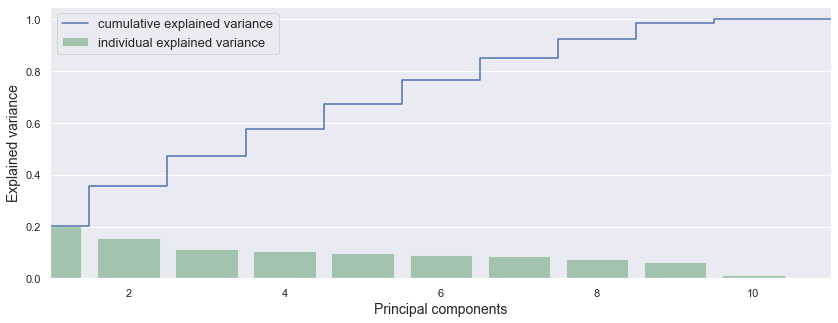

In [81]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [82]:
for i in range (3,9):
    n_clusters = i
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(scaled_matrix)
    clusters_clients = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    print('For n_clusters={}'.format(i),'silhouette score: {:<.3f}'.format(silhouette_avg))

For n_clusters=3 silhouette score: 0.237
For n_clusters=4 silhouette score: 0.277
For n_clusters=5 silhouette score: 0.287
For n_clusters=6 silhouette score: 0.229
For n_clusters=7 silhouette score: 0.227
For n_clusters=8 silhouette score: 0.231


In [83]:
n_clusters = 5
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.287


In [86]:
summary = pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T
summary = summary.append(pd.DataFrame(pd.Series(clusters_clients).value_counts()/clusters_clients.shape[0], 
                                      columns = ['nb. de clients pct']).T)
summary

,0,2,4,1,3
nb. de clients,69454.000000,22362.000000,16279.000000,13518.000000,555.000000
nb. de clients pct,0.568512,0.183043,0.133251,0.110651,0.004543


In [87]:
pca = PCA(n_components=8)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


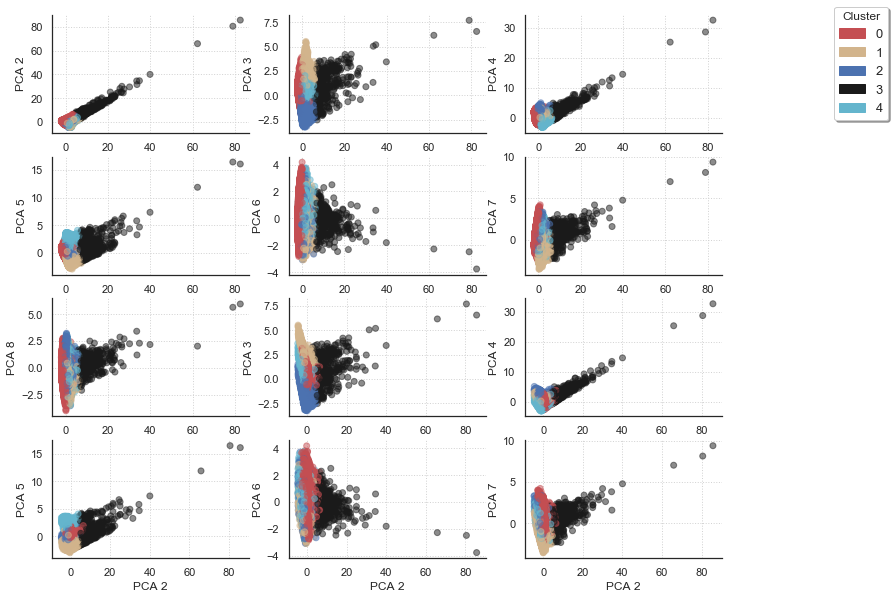

In [88]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(8):
    for iy in range(ix+1, 8):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

In [91]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
#     plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

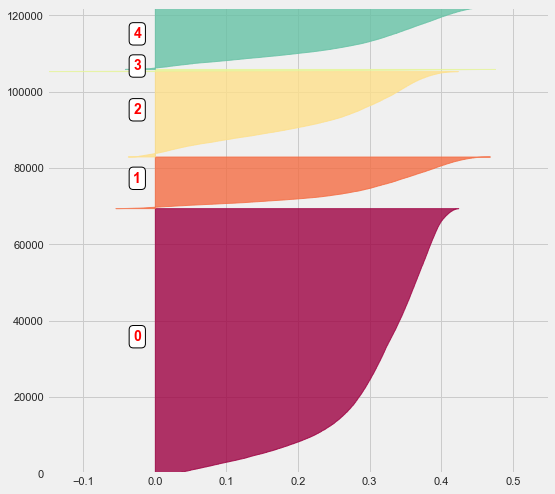

In [90]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

In [100]:
game_summary.loc[:, 'cluster'] = clusters_clients
game_summary.head()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,cluster
0,1,1,506,506.000000,100.000000,100.000000,0.000000,0.000000,0.000000,43,1,0
1,2,16,3994,249.625000,87.500000,75.000000,12.500000,0.000000,12.500000,69,0,0
2,5,218,215525,988.646789,57.089718,54.587156,44.495413,0.458716,0.458716,70,1,2
3,7,7,7781,1111.571429,40.000000,0.000000,100.000000,0.000000,0.000000,61,0,2
4,8,3325,1914368,575.749774,56.511278,25.563910,24.812030,24.812030,24.812030,56,1,1


In [130]:
game_summary.columns = game_summary.columns.get_level_values(0)

In [222]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(game_summary[game_summary['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = game_summary[game_summary['cluster'] == i].shape[0]
    test['quit_aft5'] = game_summary[(game_summary['cluster']==i) & (game_summary['solved']<=5)].shape[0]/\
                        test['size'] * 100
    test['pct'] = test['size']/game_summary.shape[0]*100
    merged_df = pd.concat([merged_df, test])
merged_df
#_____________________________________________________
merged_df.drop('user_id', axis = 1, inplace = True)
print('number of users:', merged_df['size'].sum())

merged_df = merged_df.sort_values('solved')
merged_df = merged_df.reset_index()
merged_df

number of users: 122168


,cluster,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,size,quit_aft5,pct
0,0.0,49.540775,2.435647e+04,867.070692,66.876070,93.799855,3.958904,1.198518,1.042723,42.893325,0.536672,69454,54.297809,56.851221
1,2.0,117.106744,7.749906e+04,1109.433386,68.799434,13.407095,79.904646,5.365332,1.322927,50.939048,0.623200,22362,38.668277,18.304302
2,4.0,166.993427,1.267095e+05,1248.012606,70.094226,5.192804,5.997438,83.425998,5.383760,51.584495,0.725966,16279,34.123718,13.325093
3,1.0,212.448735,1.867084e+05,1373.600553,66.105739,3.841464,1.675985,4.987127,89.495424,50.719633,0.766312,13518,30.625832,11.065091
4,3.0,8173.037838,4.441814e+06,669.479042,81.864480,17.520138,18.810333,24.524999,39.144529,64.243243,0.769369,555,0.000000,0.454292


In [318]:
clusters = merged_df.copy()
clusters['cluster'] = clusters['cluster'].map({0:'Dip the Toe',
                                               2:'Play and Chill',
                                               4:'Challenge Me',
                                               1:'More Evil Than Devil',
                                               3:'King of Puzzles'})
clusters['solved'] = clusters['solved'].apply(lambda x: round(x)).astype(int)
clusters['tot_time'] = clusters['tot_time'].apply(lambda x: str(int(x//3600))+':'\
                                                  +str(int(x%3600//60)).zfill(2)\
                                                  +':'+str(int(x%3600%60)).zfill(2))
clusters['avg_time'] = clusters['avg_time'].apply(lambda x: str(int(x%3600//60)).zfill(2)\
                                                  +':'+str(int(x%3600%60)).zfill(2))
clusters['accuracy'] = clusters['accuracy'].apply(lambda x: round(x,1))
for i in range(1,5):
    clusters['level_{}'.format(i)] = clusters['level_{}'.format(i)].apply(lambda x: round(x,1))
clusters['age'] = clusters['age'].apply(lambda x: round(x))
clusters['male'] = clusters['male'].apply(lambda x: round(x*100,1))
clusters['pct'] = clusters['pct'].apply(lambda x: round(x,1))
clusters['quit_aft5'] = clusters['quit_aft5'].apply(lambda x: round(x,1))
clusters = clusters[['cluster', 'solved', 'quit_aft5', 'tot_time', 'avg_time', 'accuracy', 'level_1',
                     'level_2', 'level_3', 'level_4', 'age', 'male', 'size', 'pct']]
cols = ['cluster', 'solved', 'quit_aft5%', 'tot_time', 'avg_time', 'accuracy%', 'easy%',
                     'medium%', 'hard%', 'evil%', 'age', 'male%', 'size', 'pct%']
clusters.columns = cols
clusters.index = np.arange(1,6)
clusters

,cluster,solved,quit_aft5%,tot_time,avg_time,accuracy%,easy%,medium%,hard%,evil%,age,male%,size,pct%
1,Dip the Toe,50,54.3,6:45:56,14:27,66.9,93.8,4.0,1.2,1.0,43,53.7,69454,56.9
2,Play and Chill,117,38.7,21:31:39,18:29,68.8,13.4,79.9,5.4,1.3,51,62.3,22362,18.3
3,Challenge Me,167,34.1,35:11:49,20:48,70.1,5.2,6.0,83.4,5.4,52,72.6,16279,13.3
4,More Evil Than Devil,212,30.6,51:51:48,22:53,66.1,3.8,1.7,5.0,89.5,51,76.6,13518,11.1
5,King of Puzzles,8173,0.0,1233:50:14,11:09,81.9,17.5,18.8,24.5,39.1,64,76.9,555,0.5


In [320]:
clusters[['cluster', 'solved', 'tot_time', 'avg_time', 'age', 'male%']]

,cluster,solved,tot_time,avg_time,age,male%
1,Dip the Toe,50,6:45:56,14:27,43,53.7
2,Play and Chill,117,21:31:39,18:29,51,62.3
3,Challenge Me,167,35:11:49,20:48,52,72.6
4,More Evil Than Devil,212,51:51:48,22:53,51,76.6
5,King of Puzzles,8173,1233:50:14,11:09,64,76.9


In [231]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

In [230]:
merged_df

,cluster,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,size,quit_aft5,pct
0,0.0,49.540775,2.435647e+04,867.070692,66.876070,93.799855,3.958904,1.198518,1.042723,42.893325,0.536672,69454,54.297809,56.851221
1,2.0,117.106744,7.749906e+04,1109.433386,68.799434,13.407095,79.904646,5.365332,1.322927,50.939048,0.623200,22362,38.668277,18.304302
2,4.0,166.993427,1.267095e+05,1248.012606,70.094226,5.192804,5.997438,83.425998,5.383760,51.584495,0.725966,16279,34.123718,13.325093
3,1.0,212.448735,1.867084e+05,1373.600553,66.105739,3.841464,1.675985,4.987127,89.495424,50.719633,0.766312,13518,30.625832,11.065091
4,3.0,8173.037838,4.441814e+06,669.479042,81.864480,17.520138,18.810333,24.524999,39.144529,64.243243,0.769369,555,0.000000,0.454292


In [258]:
mg = merged_df.copy()
mg['cluster'] = mg['cluster'].map({0:'Dip the Toe',
                                   2:'Play and Chill',
                                   4:'Challenge Me',
                                   1:'More Evil Than Devil',
                                   3:'King of Puzzles'})
mg['total time(h)'] = mg['tot_time']/3600
mg['average time(min)'] = mg['avg_time']/60
mg['male %'] = mg['male']*100
cols = ['cluster', 'solved', 'total time(h)', 'average time(min)', 'accuracy', 'level_1',
       'level_2', 'level_3', 'level_4', 'age',  'male %', 'size', 'quit_aft5', 'pct', ]
mg = mg[cols]
cols1 = ['cluster', 'solved', 'total time(h)', 'average time(min)', 'accuracy %', '% level_1',
       '% level_2', '% level_3', '% level_4', 'age', '% male', 'size', '% quit after\n5 games or less', 'pct']
mg.columns = cols1
mg

,cluster,solved,total time(h),average time(min),accuracy %,% level_1,% level_2,% level_3,% level_4,age,% male,size,% quit after 5 games or less,pct
0,Dip the Toe,49.540775,6.765687,14.451178,66.876070,93.799855,3.958904,1.198518,1.042723,42.893325,53.667175,69454,54.297809,56.851221
1,Play and Chill,117.106744,21.527515,18.490556,68.799434,13.407095,79.904646,5.365332,1.322927,50.939048,62.320007,22362,38.668277,18.304302
2,Challenge Me,166.993427,35.197081,20.800210,70.094226,5.192804,5.997438,83.425998,5.383760,51.584495,72.596597,16279,34.123718,13.325093
3,More Evil Than Devil,212.448735,51.863456,22.893343,66.105739,3.841464,1.675985,4.987127,89.495424,50.719633,76.631158,13518,30.625832,11.065091
4,King of Puzzles,8173.037838,1233.837231,11.157984,81.864480,17.520138,18.810333,24.524999,39.144529,64.243243,76.936937,555,0.000000,0.454292


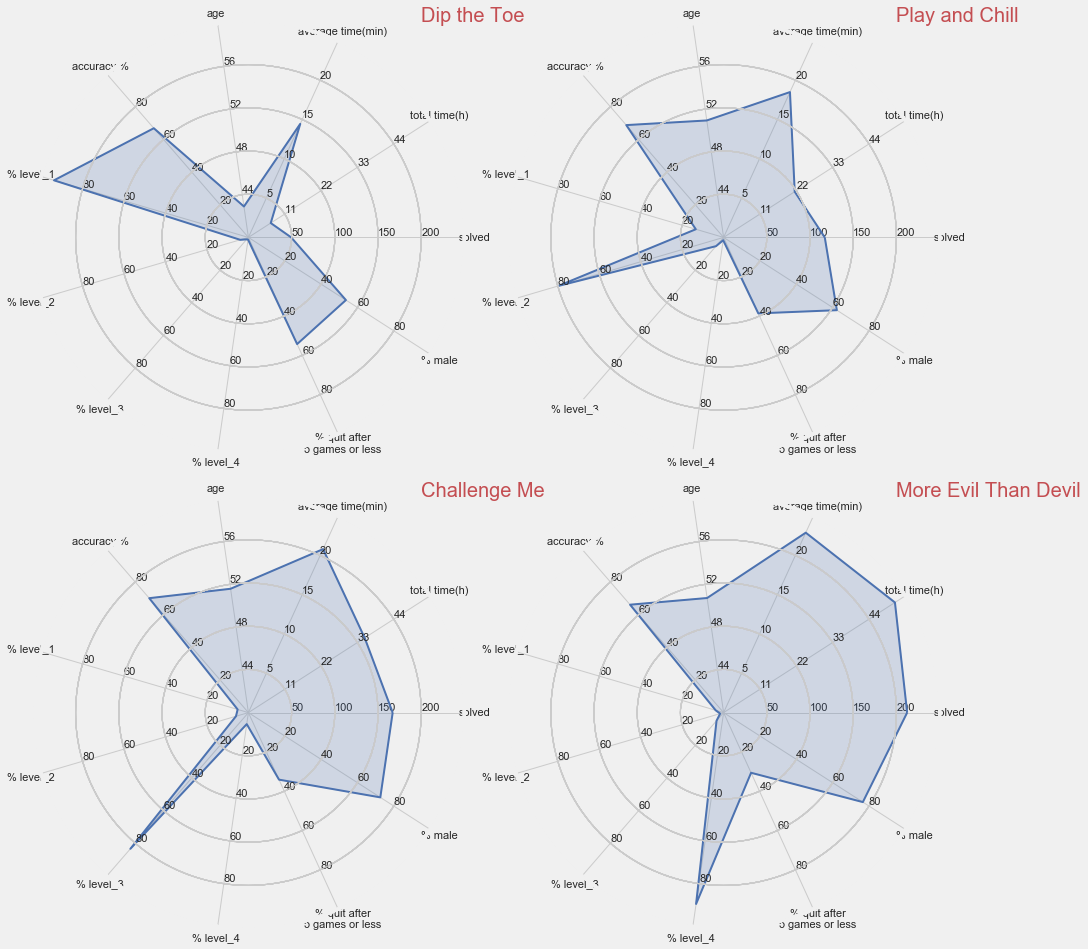

In [265]:
fig = plt.figure(figsize=(12,12))

attributes = ['solved', 'total time(h)', 'average time(min)', 'age', 'accuracy %',
              '% level_1', '% level_2', '% level_3', '% level_4', '% quit after\n5 games or less', '% male']
ranges = [[0, 250], [0, 55], [0, 25], [40, 60], [0, 100],
          [0,100], [0, 100], [0, 100], [0, 100], [0, 100], [0, 100]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters-1 ; i_cols = 2
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters-1):
    ix = ind%2 ; iy = i_rows - ind//2
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(mg.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = mg.loc[ind, 'cluster'], color = 'r',fontsize=20)
    ind += 1 

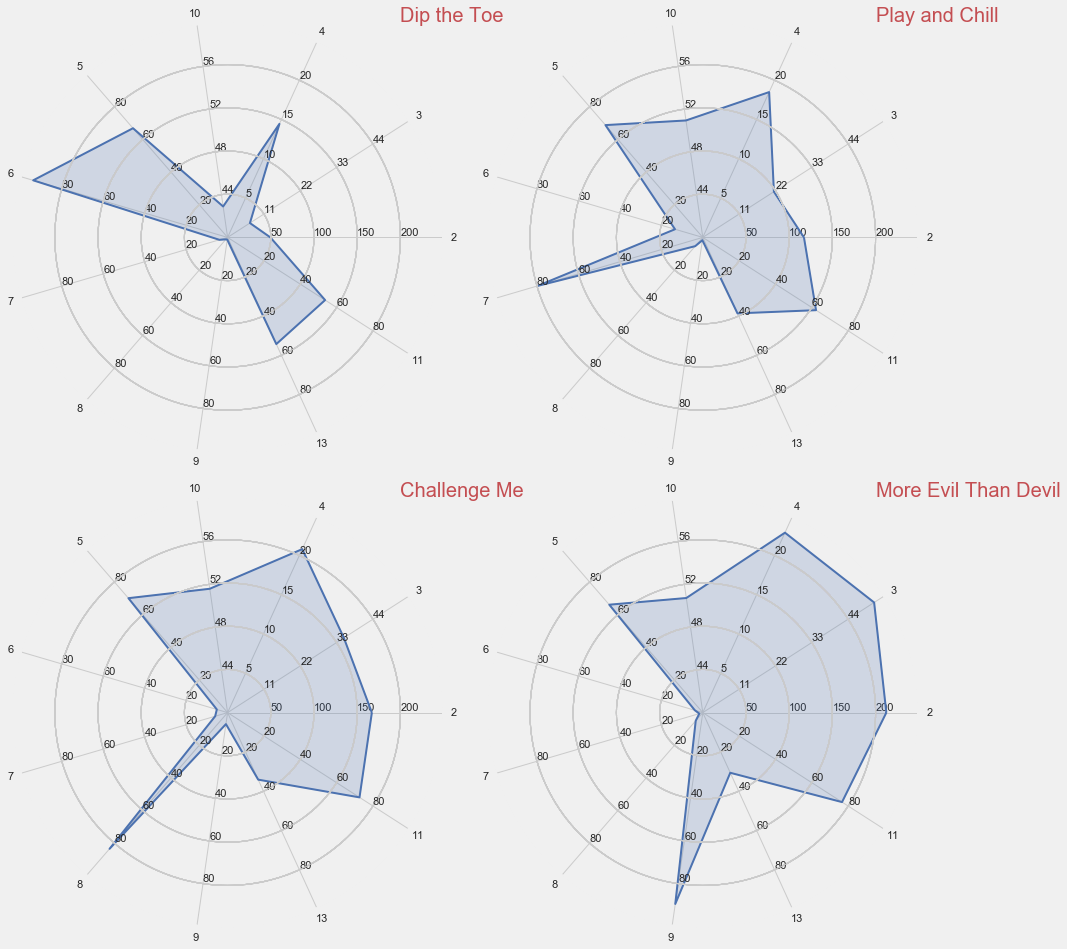

In [267]:
#cols1 = ['cluster', 'solved', 'total time(h)', 'average time(min)', 'accuracy %', '% level_1',
#       '% level_2', '% level_3', '% level_4', 'age', '% male', 'size', '% quit after\n5 games or less', 'pct']
mmg = mg.copy()
cols = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14']
mmg.columns=cols

fig = plt.figure(figsize=(12,12))

attributes = ['2', '3', '4', '10', '5',
              '6', '7', '8', '9', '13', '11']
ranges = [[0, 250], [0, 55], [0, 25], [40, 60], [0, 100],
          [0,100], [0, 100], [0, 100], [0, 100], [0, 100], [0, 100]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters-1 ; i_cols = 2
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters-1):
    ix = ind%2 ; iy = i_rows - ind//2
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(mmg.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = mg.loc[ind, 'cluster'], color = 'r',fontsize=20)
    ind += 1 

In [221]:
merged_df

,cluster,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,size,quit_aft5,pct
0,0.0,49.540775,2.435647e+04,867.070692,66.876070,93.799855,3.958904,1.198518,1.042723,42.893325,0.536672,69454,0.542978,56.851221
1,2.0,117.106744,7.749906e+04,1109.433386,68.799434,13.407095,79.904646,5.365332,1.322927,50.939048,0.623200,22362,0.386683,18.304302
2,4.0,166.993427,1.267095e+05,1248.012606,70.094226,5.192804,5.997438,83.425998,5.383760,51.584495,0.725966,16279,0.341237,13.325093
3,1.0,212.448735,1.867084e+05,1373.600553,66.105739,3.841464,1.675985,4.987127,89.495424,50.719633,0.766312,13518,0.306258,11.065091
4,3.0,8173.037838,4.441814e+06,669.479042,81.864480,17.520138,18.810333,24.524999,39.144529,64.243243,0.769369,555,0.000000,0.454292


In [192]:
easy = game_summary[game_summary.cluster==0]
easy.describe()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,cluster
count,69454.000000,69454.000000,6.945400e+04,69454.000000,69454.000000,69454.000000,69454.000000,69454.000000,69454.000000,69454.000000,69454.000000,69454.0
mean,120325.777479,49.540775,2.435647e+04,867.070692,66.876070,93.799855,3.958904,1.198518,1.042723,42.893325,0.536672,0.0
std,75685.362715,235.744898,9.167048e+04,626.911669,34.575924,14.025359,9.535254,5.253541,5.328845,19.417911,0.498657,0.0
min,1.000000,1.000000,6.000000e+01,60.000000,0.000000,7.407407,0.000000,0.000000,0.000000,2.000000,0.000000,0.0
25%,52261.000000,2.000000,1.496000e+03,487.000000,50.000000,100.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.0
50%,113090.000000,5.000000,3.827000e+03,700.000000,69.184359,100.000000,0.000000,0.000000,0.000000,38.000000,1.000000,0.0
75%,187476.500000,16.000000,1.203275e+04,1033.662088,100.000000,100.000000,0.000000,0.000000,0.000000,59.000000,1.000000,0.0
max,264633.000000,7428.000000,2.702621e+06,7131.500000,100.000000,100.000000,52.000000,51.724138,57.142857,129.000000,1.000000,0.0


In [193]:
easy[easy.solved<=5].shape[0]/easy.shape[0]

0.5429780862153367

In [218]:
easy[easy.solved<=5].describe()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,cluster
count,37712.000000,37712.000000,37712.000000,37712.000000,37712.000000,37712.000000,37712.000000,37712.000000,37712.000000,37712.000000,37712.000000,37712.0
mean,126225.253129,2.362192,2245.112325,985.982586,65.992323,97.035338,1.672500,0.560697,0.731465,41.162786,0.543673,0.0
std,75630.171389,1.324894,2009.564960,733.464207,36.994738,10.545588,7.159557,4.266909,5.165229,19.539860,0.498096,0.0
min,1.000000,1.000000,60.000000,60.000000,0.000000,20.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.0
25%,58308.250000,1.000000,903.000000,538.150000,50.000000,100.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.0
50%,123084.000000,2.000000,1643.000000,777.000000,69.184359,100.000000,0.000000,0.000000,0.000000,35.000000,1.000000,0.0
75%,193850.250000,3.000000,2892.000000,1170.850000,100.000000,100.000000,0.000000,0.000000,0.000000,57.000000,1.000000,0.0
max,264633.000000,5.000000,25865.000000,7131.500000,100.000000,100.000000,50.000000,50.000000,50.000000,129.000000,1.000000,0.0


In [198]:
easy[easy.solved>900].shape[0]/easy.shape[0]

0.01032337950298039

In [199]:
easy[easy.solved>900].describe()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,cluster
count,717.000000,717.000000,7.170000e+02,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.0
mean,94305.691771,1905.676430,6.791217e+05,379.652858,80.782349,89.152055,7.348970,2.281851,1.217123,61.213389,0.563459,0.0
std,75596.742779,1082.872839,4.049730e+05,177.839509,21.978792,17.066126,10.930681,6.396372,4.570746,14.976161,0.496303,0.0
min,32.000000,901.000000,9.643800e+04,101.365954,0.000000,24.366472,0.000000,0.000000,0.000000,19.000000,0.000000,0.0
25%,27221.000000,1111.000000,3.871870e+05,244.753402,72.356962,83.595223,0.000000,0.000000,0.000000,54.000000,0.000000,0.0
50%,72952.000000,1511.000000,5.882240e+05,346.916468,88.395685,98.773006,0.850159,0.000000,0.000000,64.000000,1.000000,0.0
75%,153351.000000,2328.000000,8.738710e+05,477.095647,96.063427,100.000000,12.332301,0.465766,0.047103,71.000000,1.000000,0.0
max,257455.000000,7428.000000,2.702621e+06,1274.868766,100.000000,100.000000,43.118280,41.304348,30.536332,107.000000,1.000000,0.0


In [165]:
game_summary[game_summary.solved==7428]

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,cluster
113645,236321,7428,810966,109.176898,14.959511,100.0,0.0,0.0,0.0,22,0,0


In [200]:
medium = game_summary[game_summary.cluster==2]
medium.describe()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,cluster
count,22362.000000,22362.000000,2.236200e+04,22362.000000,22362.000000,22362.000000,22362.000000,22362.000000,22362.000000,22362.000000,22362.000000,22362.0
mean,123481.573294,117.106744,7.749906e+04,1109.433386,68.799434,13.407095,79.904646,5.365332,1.322927,50.939048,0.623200,2.0
std,74595.061466,371.238622,2.094740e+05,731.121526,31.333990,17.838672,22.054075,10.977863,5.364285,19.501016,0.484595,0.0
min,5.000000,1.000000,6.900000e+01,63.000000,0.000000,0.000000,19.742489,0.000000,0.000000,2.000000,0.000000,2.0
25%,57463.750000,3.000000,3.214250e+03,624.867925,54.021614,0.000000,60.000000,0.000000,0.000000,32.000000,0.000000,2.0
50%,122297.500000,10.000000,1.051550e+04,919.666667,75.000000,0.985246,89.285714,0.000000,0.000000,54.000000,1.000000,2.0
75%,186554.250000,59.000000,4.918800e+04,1377.000000,96.449526,25.286272,100.000000,3.592939,0.000000,67.000000,1.000000,2.0
max,264621.000000,6800.000000,2.941091e+06,7175.000000,100.000000,66.666667,100.000000,53.333333,50.000000,129.000000,1.000000,2.0


In [203]:
medium[medium.solved<=10].shape[0]/medium.shape[0]

0.5092567748859672

In [209]:
medium.solved.quantile(0.97)

902.0

In [210]:
medium[medium.solved>900].describe()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,cluster
count,672.000000,672.000000,6.720000e+02,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.0
mean,100462.145833,1839.660714,9.707109e+05,564.389521,80.847005,12.845735,76.051679,9.159230,1.943357,63.272321,0.656250,2.0
std,72969.183462,969.504774,5.301964e+05,262.137946,22.284360,17.199624,24.323728,12.558780,5.669591,13.098342,0.475313,0.0
min,302.000000,902.000000,1.932260e+05,142.154604,0.000000,0.000000,23.630832,0.000000,0.000000,14.000000,0.000000,2.0
25%,37047.500000,1128.500000,5.780005e+05,378.159847,72.709068,0.074413,53.140518,0.000000,0.000000,57.000000,0.000000,2.0
50%,90389.000000,1506.500000,8.219180e+05,522.999001,89.251161,1.832721,84.531835,1.460938,0.000000,65.000000,1.000000,2.0
75%,162919.750000,2259.250000,1.233986e+06,687.351977,96.754895,23.999949,99.188414,17.283015,0.331956,72.000000,1.000000,2.0
max,261825.000000,6800.000000,2.941091e+06,1910.507205,100.000000,64.200252,100.000000,48.407643,43.167203,125.000000,1.000000,2.0


In [168]:
game_summary[game_summary.cluster==4].describe()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,cluster
count,16279.000000,16279.000000,1.627900e+04,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.000000,16279.0
mean,116821.016279,166.993427,1.267095e+05,1248.012606,70.094226,5.192804,5.997438,83.425998,5.383760,51.584495,0.725966,4.0
std,75468.305798,440.552130,2.972576e+05,823.263914,30.126382,11.387841,11.529238,20.400152,11.474777,18.201885,0.446040,0.0
min,12.000000,1.000000,9.500000e+01,70.666667,0.000000,0.000000,0.000000,24.045160,0.000000,5.000000,0.000000,4.0
25%,49260.500000,3.000000,4.289500e+03,683.730137,59.658387,0.000000,0.000000,66.666667,0.000000,35.000000,0.000000,4.0
50%,110837.000000,16.000000,1.776700e+04,1027.400000,75.000000,0.000000,0.000000,95.924309,0.000000,54.000000,1.000000,4.0
75%,181410.500000,107.000000,9.618550e+04,1572.020572,97.035628,2.836879,5.882353,100.000000,3.094379,66.000000,1.000000,4.0
max,264689.000000,5275.000000,3.061285e+06,7182.000000,100.000000,66.666667,53.058321,100.000000,53.284672,129.000000,1.000000,4.0


In [170]:
game_summary[game_summary.cluster==1].describe()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,cluster
count,13518.000000,13518.000000,1.351800e+04,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,13518.0
mean,116825.892292,212.448735,1.867084e+05,1373.600553,66.105739,3.841464,1.675985,4.987127,89.495424,50.719633,0.766312,1.0
std,77063.046349,479.702669,3.892497e+05,962.281102,33.019118,10.110949,5.502183,10.450926,16.905769,17.596880,0.423192,0.0
min,8.000000,1.000000,6.800000e+01,61.026667,0.000000,0.000000,0.000000,0.000000,18.582047,2.000000,0.000000,1.0
25%,47737.500000,4.000000,5.397500e+03,716.474832,50.000000,0.000000,0.000000,0.000000,83.333333,36.000000,1.000000,1.0
50%,109978.500000,25.000000,2.960400e+04,1107.050000,71.428571,0.000000,0.000000,0.000000,100.000000,53.000000,1.000000,1.0
75%,183212.500000,172.000000,1.702695e+05,1727.800000,97.043271,0.538866,0.000000,3.225806,100.000000,65.000000,1.000000,1.0
max,264679.000000,5017.000000,3.576555e+06,7109.000000,100.000000,66.666667,50.000000,52.104664,100.000000,129.000000,1.000000,1.0


In [171]:
game_summary[game_summary.cluster==3].describe()

,user_id,solved,tot_time,avg_time,accuracy,level_1,level_2,level_3,level_4,age,male,cluster
count,555.000000,555.000000,5.550000e+02,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.0
mean,74787.592793,8173.037838,4.441814e+06,669.479042,81.864480,17.520138,18.810333,24.524999,39.144529,64.243243,0.769369,3.0
std,68449.326897,7304.583411,2.874390e+06,400.675310,21.253480,31.812081,30.508949,34.049993,43.681518,10.486209,0.421616,0.0
min,24.000000,1334.000000,6.710910e+05,85.503028,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,3.0
25%,14537.000000,4767.000000,2.834024e+06,390.379841,75.386261,0.009480,0.000000,0.024893,0.009554,59.000000,1.000000,3.0
50%,55336.000000,6295.000000,3.693252e+06,577.815507,89.789750,0.216533,1.018397,5.208333,12.843030,65.000000,1.000000,3.0
75%,125523.000000,9078.500000,5.093123e+06,838.671943,96.936674,20.134813,25.021203,36.819165,94.737978,71.000000,1.000000,3.0
max,258110.000000,94493.000000,2.907426e+07,3295.777336,100.000000,100.000000,100.000000,100.000000,100.000000,97.000000,1.000000,3.0


In [191]:
hundred = game_summary[game_summary.solved>00]
hundred.age.corr(hundred.solved)

0.10591159026017731

In [216]:
age = game_summary[['solved', 'age']].copy()
age['solved'] = (age['solved'] - age['solved'].mean())/age['solved'].std()
age['age'] = (age['age'] - age['age'].mean())/age['age'].std()
age.corr()

,solved,age
solved,1.000000,0.105912
age,0.105912,1.000000
